# Bottleneck Distance

This week in lecture, we defined a metric on the space of persistence diagrams. 

Recall that a *persistence diagram* is a finite (multi-)set of ordered pairs
$$
\mathcal{D} = \{(b_i,d_i)\}_{i=1}^N,
$$
with $0 \leq b_i < d_i \leq \infty$ for all $i$. Let $\mathrm{PDiag}$ denote the set of all persistence diagrams.

The *bottleneck distance* between persistence diagrams $\mathcal{D} = \{(b_i,d_i)\}_{i=1}^N$ and $\mathcal{D}' = \{(b_i',d_i')\}_{i=1}^{N'}$ is
$$
d_b(\mathcal{D},\mathcal{D}') = \min_{\phi:S \to S'} \max \left\{\max_{(b,d) \in S} d_\infty((b,d),\phi(b,d)), \max_{(b,d) \not \in S} \delta_\infty(b,d), \max_{(b',d') \not \in S'} \delta_\infty(b',d') \right\},
$$
where
- the minimum is over *partial bijections* $\phi:S \to S'$,
- $d_\infty((b,d),(b',d')) = \max\{|b - b'|, |d-d'|\}$,
- $\delta_\infty(b,d) = \frac{d-b}{2}$.

In this notebook, we'll explore bottleneck distance on some data.

In [1]:
# Standard packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from sklearn.metrics import pairwise_distances

# For loading data
import os 
from os.path import dirname, join as pjoin
import scipy.io as sio

# TDA packages
import gudhi as gd
from ripser import ripser
import persim
from persim import plot_diagrams 

## Loading and Exploring the Data

To experiment with bottleneck distance, we'll load a simple computer vision dataset. The data consists of a large number of densely sampled plane curves representing various objects (bones, dogs, cars, etc.). The following code block reads and processes the data. You can take a look at each piece separately to see what's going on, if you're interested.

In [6]:
data_dir = os.getcwd() # Get the current working directory name.
mat_fname = pjoin(data_dir, './data/planarShapes.mat') 
# Add the file name to the current working directory.

mat_contents = sio.loadmat(mat_fname) # Read the file
planarShapes = mat_contents['planarShapes']

In [7]:
planarShapes.shape

(2, 100, 1300)

The line above shows that planarShapes is a 2x100x1300 array. Exploring more, we would find that there are 1300 separate shapes, separated into 20 copies of similar shapes (so 65 classes of similar shapes). Each of the 1300 shapes is a pointcloud in $\mathbb{R}^2$ consisting of 100 points.

We would prefer each shape to be of shape num_points-by-dimension, since this is the usual convention in Python code.

In [8]:
planarShapes = planarShapes.transpose(1, 0, 2)

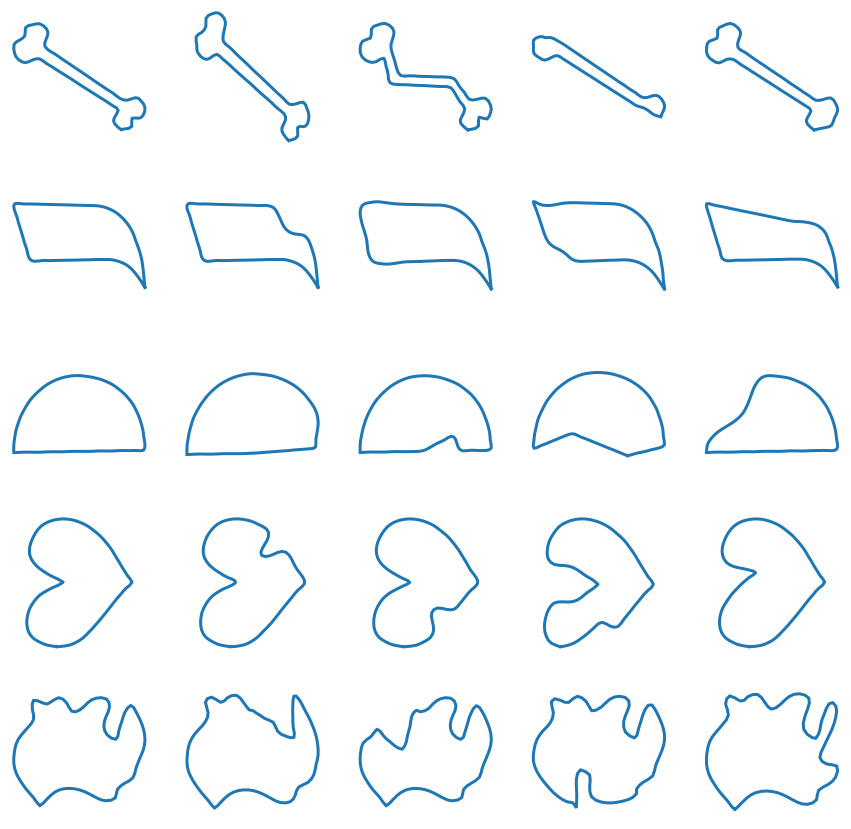

In [9]:
shape_indices = [4*x for x in range(25)]

fig = plt.figure(figsize = (15,15))

for j in range(25):
    ax = fig.add_subplot(5,5,j+1)
    shape = planarShapes[:,:,shape_indices[j]]
    ax.plot(shape[:,0], shape[:,1], linewidth=3)
    ax.axis('off')
    ax.axis('equal')

The above code plots the shapes as continuous curves, but the data for each shape is really a point cloud.

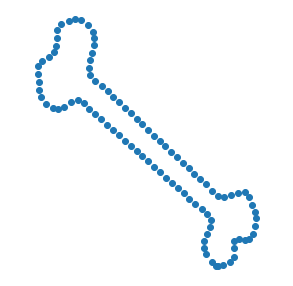

In [10]:
plt.figure(figsize=(5,5))
shape = planarShapes[:,:,4]
plt.scatter(shape[:,0], shape[:,1])
plt.axis('off')
plt.axis('equal');

### Initial Experiments with Bottleneck Distance

Let's fix some shapes to use for examples.

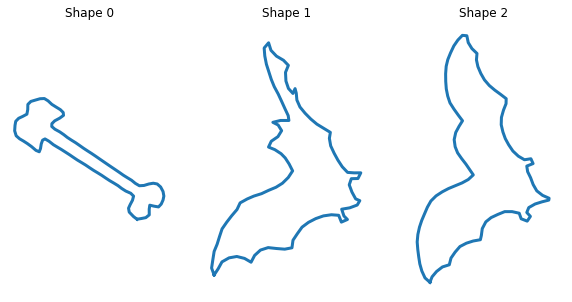

In [11]:
shape_indices = [1,125,127] # Pick some shapes.

num_shapes = len(shape_indices) 
# If you want to pick different shape indices it will be useful to save this as variable.

fig = plt.figure(figsize = (10,5))

for j in range(num_shapes):
    ax = fig.add_subplot(1,3,j+1)
    shape = planarShapes[:,:,shape_indices[j]]
    ax.plot(shape[:,0], shape[:,1], linewidth=3)
    ax.axis('off')
    plt.title('Shape '+str(j))
    ax.axis('equal')

Let's compute persistence diagrams for these examples, then look at bottleneck distances between them. 

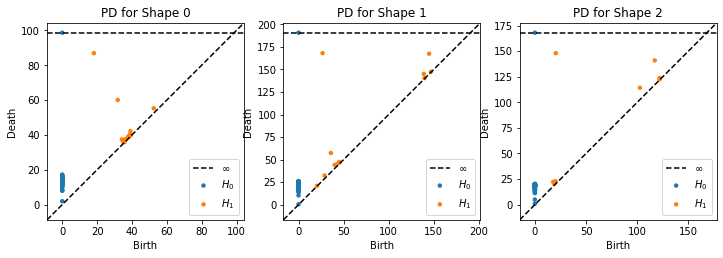

In [12]:
shapeDgms = [ripser(planarShapes[:,:,shape_indices[j]])['dgms'] for j in range(num_shapes)]

fig = plt.figure(figsize=(12,4))

for j in range(num_shapes):
    ax = fig.add_subplot(1,num_shapes,j+1) # You might need to change this layout if you change shape_indices
    plt.title('PD for Shape '+str(j), fontsize = 12)
    plot_diagrams(shapeDgms[j])

The "persim" package includes several distance metrics between persistence diagrams, including the bottleneck distance that we have defined in class. Let's compute bottleneck distances between our shape examples. There is an option to not only compute the distance, but to record the optimal matching which produces it. In the first example, we compute the bottleneck distance between the degree-1 persistence diagrams for shapes with indices 0 and 1.

In [13]:
distance_bottleneck, (matching, D) = persim.bottleneck(shapeDgms[0][1], shapeDgms[1][1], matching=True)
print(distance_bottleneck)

70.71136951446533


We can then plot the persistence diagrams on the same axes and display the optimal matching. The green line segment indicates matched points (or point which is matched to the diagonal) incurring the highest cost; i.e., the matching which realizes the distance.

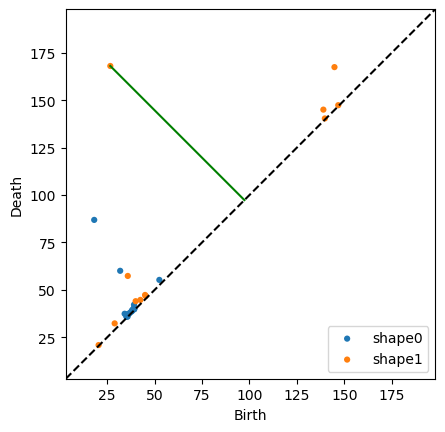

In [14]:
persim.visuals.bottleneck_matching(shapeDgms[0][1], shapeDgms[1][1], matching, D, labels=['shape0', 'shape1'])

Let's also compute the distance between shapes with indices 0 and 2.

In [15]:
distance_bottleneck, (matching, D) = persim.bottleneck(shapeDgms[0][1], shapeDgms[2][1], matching=True)
print(distance_bottleneck)

61.09130859375


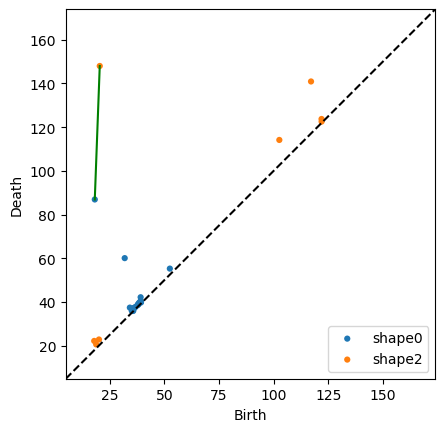

In [16]:
persim.visuals.bottleneck_matching(shapeDgms[0][1], shapeDgms[2][1], matching, D, labels=['shape0', 'shape2'])

Finally, we compute the distance between shapes 1 and 2.

20.066848754882812


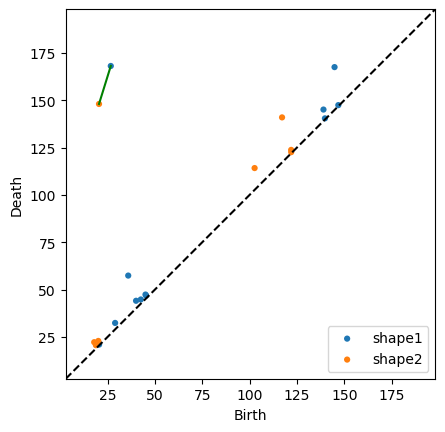

In [17]:
distance_bottleneck, (matching, D) = persim.bottleneck(shapeDgms[1][1], shapeDgms[2][1], matching=True)
print(distance_bottleneck)

persim.visuals.bottleneck_matching(shapeDgms[1][1], shapeDgms[2][1], matching, D, labels=['shape1', 'shape2'])

So bottleneck distance seems to pick up on differences in the shapes. We can summarize the distances by computing a *distance matrix*. Since we are comparing 3 shapes, the distance matrix will be a $3 \times 3$ matrix whose $(i,j)$-entry is the bottleneck distance between Shape $i$ and Shape $j$.

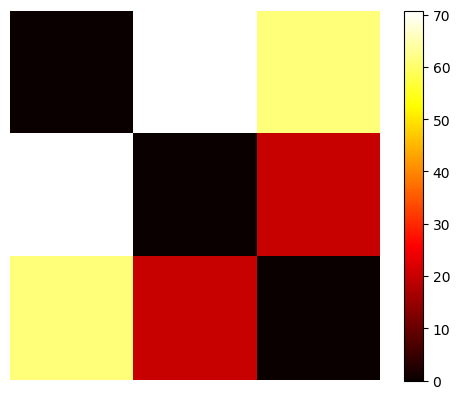

In [18]:
# Compute the distance matrix
distMat = np.zeros((3,3))

for i in range(3):
    for j in range(3):
        distMat[i,j] = persim.bottleneck(shapeDgms[i][1], shapeDgms[j][1], matching=True)[0]
        
# Display the distance matrix
img = plt.imshow(distMat)
img.set_cmap('hot')
plt.colorbar()
plt.axis('off');

## Classification Experiment

Let's now try a simple supervised learning experiment. We'll pick several shape classes, then several examples of shapes from each class. The goal is to see whether bottleneck distance between persistence diagrams will work as a classifier for the shapes.

In [20]:
shape_classes = [0,100,200,300,400] # Pick indices of shape classes to sample.
num_classes = len(shape_classes)
num_shapes = 20
# Pick number of examples to take from each shape class
# Pick carefully so that we get shapes from the same class!
# Remember the shapes come in groups of 20

# Create labels for the data
labels = []

for j in range(num_classes):
    labels = labels + num_shapes*[j]

# List all indices of the shape samples for the experiment.
samples =[]
for j in range(num_classes):
    samples = samples+list(range(shape_classes[j],shape_classes[j]+num_shapes))

# We now pick out the shapes with indices in 'samples' and preprocess.
num_samp = len(samples)

shapeSamples_tmp = [planarShapes[:,:,samples[j]] for j in range(num_samp)]

To make the classification more difficult, I'm going to make it more difficult by permuting the points in each shape. As provided, the points in the shape are 'in order'---i.e., they correspond to a parameterization of the underlying curve. This makes the classification very easy: *Procrustes distance* will do the trick for us very well. When the points are disordered, Procrustes distance fails and we would need to add an extra step of finding point correspondences between shapes.

Persistent homology is completely agnostic to ordering of the points, so this permutation won't effect performance. This point reordering is artificial in this example, but not having point correspondences handed to you wouldn't be unusual for real data. Especially when the point clouds come from, say, 3D shapes.

We're also adding a bit of random noise to the shapes.

In [21]:
shapeSamples = [np.matmul(np.eye(100)[np.random.permutation(100),:],shape) + 0.1*np.random.rand(100,2) for shape in shapeSamples_tmp]

Let's take a look at shapes from each of the shape classes. Points are colored by the order in which they appear in the permuted list of points (i.e., the coloring should look random here).

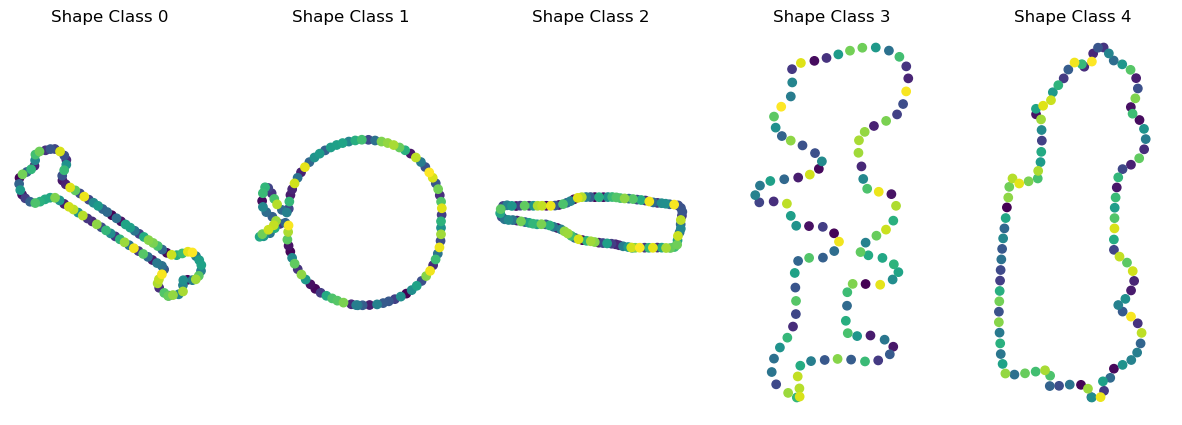

In [22]:
fig = plt.figure(figsize=(15,5))

for j in range(num_classes):
    shape_example = shapeSamples[j*num_shapes]
    ax = fig.add_subplot(1,num_classes,j+1)
    ax.scatter(shape_example[:,0], shape_example[:,1], c = list(range(100)))
    plt.title('Shape Class '+str(j))
    ax.axis('off')
    ax.axis('equal')
    

Let's also look at the samples within a given class of shapes.

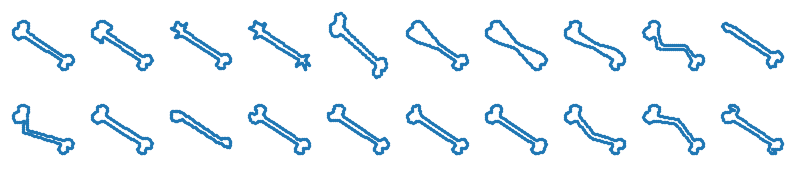

In [23]:
fig = plt.figure(figsize=(10,2))

for j in range(num_shapes):
    shape_example = shapeSamples[j]
    ax = fig.add_subplot(2,int(np.ceil(num_shapes)/2),j+1)
    ax.scatter(shape_example[:,0], shape_example[:,1], s = 2)
    ax.axis('off')
    ax.axis('equal')

## Nearest Neighbors Classification

Now we'll use a simple classification model called $k$-Nearest Neighbors (kNN) to see whether persistent homology does a good job at classifying shapes. The idea is simple:
- We divide our data up into a 'training set' with 80% of samples and a 'testing set' with the remaining 20%
- For each shape in the testing set, we look for the $k$ closest points to that shape in the training set, with respect to bottleneck distance on degree-1 persistent homology. 
- The shape class that the majority of nearest neighbors belong to is our guess for the shape class of the test point
- If we guess the correct shape class, we get a 'win' for that shape, otherwise we get a 'loss'.
- We count the number of wins and divide by the size of the test set to get an accuracy.

I'll use some `sklearn` functions to run this experiment, which prefer data to be in the shape of a vector. I'll reshape each 100x2 shape into a length 200 vector.

In [24]:
X = [shapeSamples[j].reshape(200,) for j in range(num_samp)]
y = labels

For comparison, I'll also run the experiment using Procrustes distance: this takes two shapes and tries to line them up over rotations and translations. Then it computes the total distance between aligned points. 

**Disclaimer:** I've (purposefully) messed up the order of the points, so this won't really be a fair comparison...

We need functions for our distance metrics to plug into the `sklearn` functions.

In [25]:
from scipy.spatial import procrustes

def procDist(X,Y):
    X1 = X.reshape(100,2)
    Y1 = Y.reshape(100,2)
    m1, m2, disp = procrustes(X1, Y1)
    return disp

In [26]:
def bottleneckDist(X,Y):
    X1 = X.reshape(100,2)
    Y1 = Y.reshape(100,2)
    dgm1 = ripser(X1)['dgms'][1]
    dgm2 = ripser(Y1)['dgms'][1]
    return persim.bottleneck(dgm1, dgm2)   

Now we do the train/test split.

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=1)

Finally, we run the kNN classification. You can change the `n_neighbors` parameter (this is the $k$ in kNN).

In [28]:
from sklearn.neighbors import KNeighborsClassifier

# Define the bottleneck distance model and fit
neighBottleneck = KNeighborsClassifier(n_neighbors=3, metric = bottleneckDist)
neighBottleneck.fit(X_train, y_train) 

# Define the Procrustes distance model and fit
neighProc = KNeighborsClassifier(n_neighbors=3, metric = procDist)
neighProc.fit(X_train, y_train) 

KNeighborsClassifier(metric=<function procDist at 0x7ff1cdf59b90>,
                     n_neighbors=3)

Now we find the classification rate for each metric on the testing set. This takes a while, by the nature of $k$NN, the fact that we are using callable functions as our metrics, and the slowness of the bottleneck distance computation.

In [29]:
neighBottleneck.score(X_test,y_test)

0.9

In [30]:
neighProc.score(X_test,y_test)

0.15

We see that bottleneck distance performs relatively well! On the other hand, the 'standard' metric, Procrustes distance, does poorly. This is due to the random ordering of the points. It could be improved by finding point correspondes via, say, iterative closest point methods. This becomes more difficult in higher dimensions. Persistent homology is naturally invariant under point ordering and other isometries, such as rigid alignment of shapes.

We can look at where the misclassifications were for bottleneck distance by looking at the *confusion matrix*.

In [31]:
from sklearn import metrics
predictedBottleneck = neighBottleneck.predict(X_test)
print(metrics.confusion_matrix(y_test, predictedBottleneck))

[[3 0 0 0 1]
 [0 3 0 0 1]
 [0 0 4 0 0]
 [0 0 0 4 0]
 [0 0 0 0 4]]
